# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk

DEPRECATION: tensorflowjs 2.0.1 has a non-standard dependency specifier tensorflow-cpu>=2.1.0<3. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorflowjs or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [469]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [470]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


In [471]:
def create_character_document_from_dataframe(df, max_line_count):
    character_docs = {}
    character_line_count = {}

    # Group by episode and scene for context extraction
    grouped = df.groupby(['Episode', 'Scene'])

    for _, group in grouped:
        # Reset index within the group
        group = group.reset_index(drop=True)

        for index, row in group.iterrows():
            name = row['Character_name']
            line = row['Line']

            # Remove empty lines
            if isinstance(line, float) and math.isnan(line):
                continue

            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0

            if character_line_count[name] < max_line_count:
                character_docs[name] += str(line) + " _EOL_ "
                character_line_count[name] += 1

                # Adding context: previous and next lines from different characters in the same scene
                if index > 0:  # Previous line context
                    prev_row = group.iloc[index - 1]
                    if prev_row['Character_name'] != name:
                        character_docs[name] += "Context: " + str(prev_row['Line']) + " _EOL_ "
                if index < len(group) - 1:  # Next line context
                    next_row = group.iloc[index + 1]
                    if next_row['Character_name'] != name:
                        character_docs[name] += "Context: " + str(next_row['Line']) + " _EOL_ "
    print("lines per character", character_line_count)
    return character_docs

In [472]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Monica Geller Number of Words:  10242
Joey Tribbiani Number of Words:  9511
Chandler Bing Number of Words:  10117
Phoebe Buffay Number of Words:  9717
#ALL# Number of Words:  8271
Ross Geller Number of Words:  9153
Rachel Green Number of Words:  10730
Other_None Number of Words:  9031
Other_Female Number of Words:  9502
Other_Male Number of Words:  10036
total words 96310


In [473]:
import re
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
import nltk
from nltk.corpus import wordnet

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(treebank_tag):
    """Converts treebank tags to WordNet part of speech tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def pre_process(character_text, use_pos=True, use_stem=True, use_lemma=True, use_stopwords=False, use_ngrams=True, handle_negations=True):
    """
    Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization, and other techniques.
    """
    if not isinstance(character_text, str):
        return []

    # Initialize necessary tools
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    # 1. Case Normalization
    character_text = character_text.lower()

    # 2. Handle negations (e.g., "not good" -> "not_good")
    if handle_negations:
        character_text = re.sub(r'\bnot\s', 'not_', character_text)

    # 3. Punctuation Removal
    character_text = character_text.translate(str.maketrans('', '', string.punctuation))

    # 4. Tokenization
    tokens = word_tokenize(character_text)

    # 5. Stop Words Removal
    if use_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # 6. POS Tagging and 7. Lemmatization
    if use_pos and use_lemma:
        pos_tags = pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    elif use_lemma:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # 8. Stemming
    if use_stem:
        tokens = [stemmer.stem(token) for token in tokens]

    # 9. N-Grams
    if use_ngrams:
        bigrams = ['_'.join(gram) for gram in ngrams(tokens, 2)]
        trigrams = ['_'.join(gram) for gram in ngrams(tokens, 3)]
        tokens.extend(bigrams)
        tokens.extend(trigrams)

    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abdulrahmanqadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdulrahmanqadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abdulrahmanqadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/abdulrahmanqadi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / accuracy: 0.4
mean rank 3.2
mean cosine similarity 0.8790044469202407
4 correct out of 10 / ac

In [474]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [475]:
from nltk.sentiment import SentimentIntensityAnalyzer

def to_feature_vector_dictionary(character_doc, extra_features=None):
    """
    Converts a list of pre-processed tokens and extra features to a Dictionary 
    as a function of the tokens. Enhanced to include sentiment scores and more.
    """
    # Initialize Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Basic token counts
    counts = Counter(character_doc)

    # N-gram features (bigrams and trigrams)
    for n in range(2, 4):
        for ngram in ngrams(character_doc, n):
            counts["_".join(ngram)] += 1

    # POS tag features
    pos_tags = nltk.pos_tag(character_doc)
    pos_counts = Counter(tag for word, tag in pos_tags)
    counts.update(pos_counts)

    # Sentiment Analysis
    sentiment_score = sia.polarity_scores(' '.join(character_doc))
    for key in sentiment_score:
        counts[f"sentiment_{key}"] = sentiment_score[key]

    # Add extra features if provided
    if extra_features:
        for feature in extra_features:
            counts[feature] += 1

    return dict(counts)

In [554]:
# Adjust the parameter grid to match the parameters accepted by pre_process()
param_grid_q2 = {
    'use_stem': [True, False],
    'use_lemma': [True, False],
    'use_stopwords': [True, False],
    'use_ngrams': [True, False],
    'handle_negations': [True, False]
    # Note: Removed 'include_ngrams' and 'include_sentiment'
}

best_params_q2 = None
best_performance_q2 = float('inf')

for params in product(*param_grid_q2.values()):
    params_dict = dict(zip(param_grid_q2.keys(), params))

    # Preprocess the corpus
    preprocessed_training_corpus = [' '.join(pre_process(doc, **params_dict)) for doc, _ in training_corpus]
    preprocessed_val_corpus = [' '.join(pre_process(doc, **params_dict)) for doc, _ in val_corpus]

    # Apply TF-IDF transformation
    tfidf_vectorizer = TfidfVectorizer()
    training_feature_matrix = tfidf_vectorizer.fit_transform(preprocessed_training_corpus)
    val_feature_matrix = tfidf_vectorizer.transform(preprocessed_val_corpus)

    # Compute the performance
    mean_rank, _, _, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

    if mean_rank < best_performance_q2:
        best_performance_q2 = mean_rank
        best_params_q2 = params_dict

# Print the best parameters and their performance
print("Best Parameters for Question 2:", best_params_q2)
print("Best Performance for Question 2:", best_performance_q2)

<ipython-input-539-f74403f14492>:7: RuntimeWarning: invalid value encountered in double_scalars
  manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))


mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.9
mean cosine similarity nan
1 correct out of 10 / accuracy: 0.1
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy

In [535]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_document_matrix_from_corpus(corpus, fitting=True, vectorizer=None):
    """
    Creates a document matrix from the corpus with TF-IDF transformation.
    Assumes that the input corpus is a list of strings (each representing a document).
    """
    if fitting:
        # Initialize and fit the TfidfVectorizer for training data
        tfidf_vectorizer = TfidfVectorizer()
        document_matrix = tfidf_vectorizer.fit_transform(corpus)
    else:
        # Use the provided vectorizer to transform the validation or test data
        document_matrix = vectorizer.transform(corpus)

    return document_matrix, tfidf_vectorizer if fitting else vectorizer

# Convert preprocessed corpus into feature dictionaries
training_feature_dicts = [''.join(to_feature_vector_dictionary(doc)) for doc in preprocessed_training_corpus]
val_feature_dicts = [''.join(to_feature_vector_dictionary(doc)) for doc in preprocessed_val_corpus]

# Create the document matrices
training_feature_matrix, tfidf_vectorizer = create_document_matrix_from_corpus(training_feature_dicts, fitting=True)
val_feature_matrix, _ = create_document_matrix_from_corpus(val_feature_dicts, fitting=False, vectorizer=tfidf_vectorizer)

In [536]:
training_feature_matrix

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [537]:
val_feature_matrix

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [538]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
Num. Characters:  10 

Other_None Num of Words:  987
Rachel Green Num of Words:  992
Other_Male Num of Words:  996
Ross Geller Num of Words:  691
#ALL# Num of Words:  460
Phoebe Buffay Num of Words:  899
Chandler Bing Num of Words:  931
Monica Geller Num of Words:  887
Joey Tribbiani Num of Words:  721
Other_Female Num of Words:  1236
total words 8800


In [539]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [540]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [541]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [542]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0


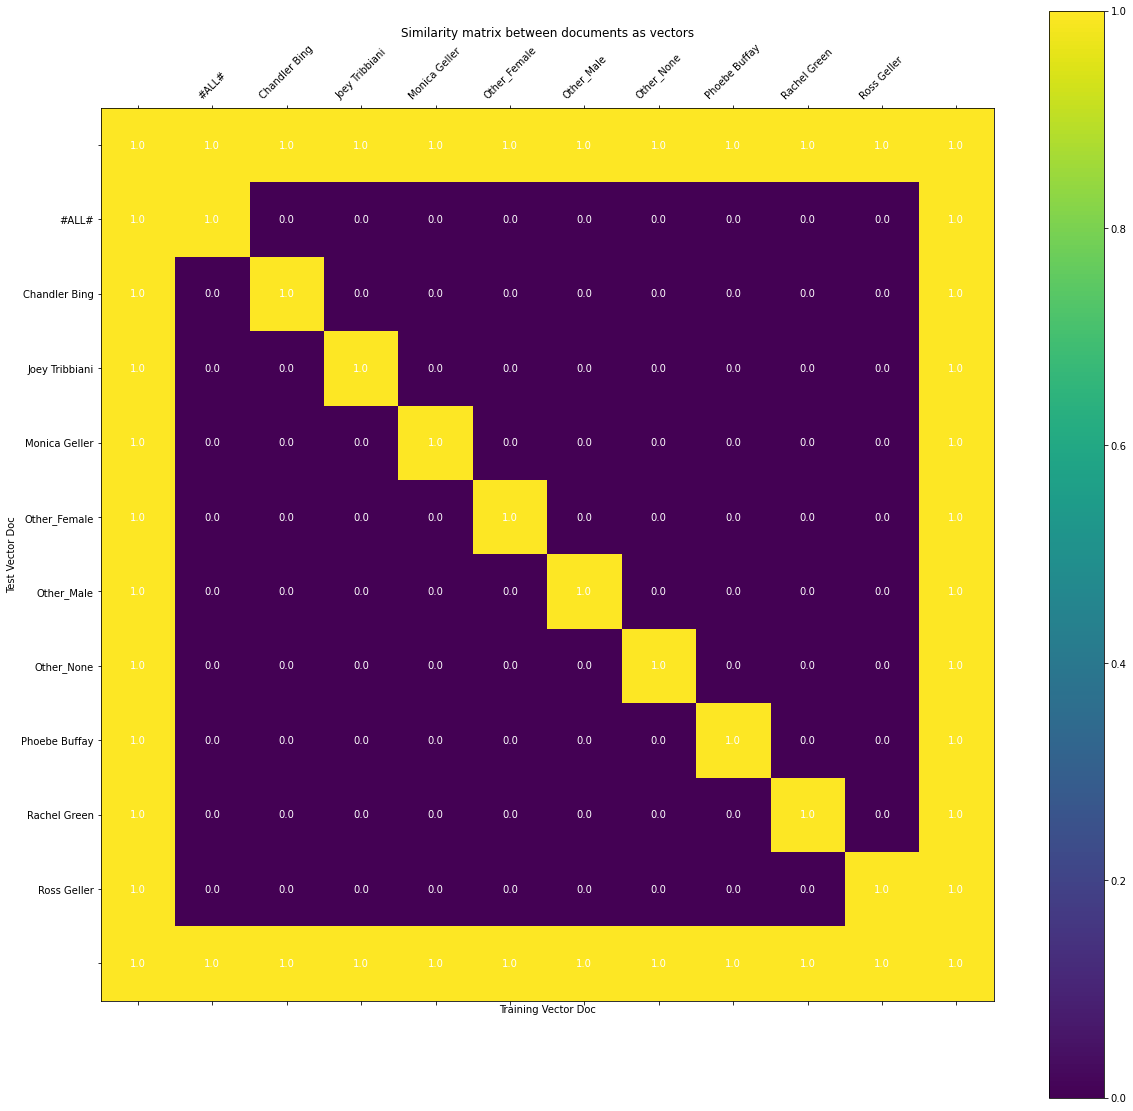

In [543]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. 

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more 
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [501]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix, dict_vectorizer = create_document_matrix_from_corpus(training_feature_dicts, fitting=True)

# get the test data using 30 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

preprocessed_test_corpus = [pre_process(doc) for doc, _ in test_corpus]
test_feature_dicts = [to_feature_vector_dictionary(doc) for doc in preprocessed_test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix, _ = create_document_matrix_from_corpus(test_feature_dicts, fitting=False, vectorizer=dict_vectorizer)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Monica Geller Number of Words:  10242
Joey Tribbiani Number of Words:  9511
Chandler Bing Number of Words:  10117
Phoebe Buffay Number of Words:  9717
#ALL# Number of Words:  8271
Ross Geller Number of Words:  9153
Rachel Green Number of Words:  10730
Other_None Number of Words:  9031
Other_Female Number of Words:  9502
Other_Male Number of Words:  10036
total words 96310
lines per character {'Ross Geller': 30, 'Joey Tribbiani': 30, 'Chandler Bing': 30, 'Other_Female': 30, 'Other_None': 30, '#ALL#': 11, 'Monica Geller': 30, 'Rachel Green': 30, 'Phoebe Buffay': 30, 'Other_Male': 30}
Num. Characters:  10 

Ross Geller Number of Words:  1106
Joey Tribbiani Number of Words:  1045
Chandler Bing Number of Words:  905
Other_Female Number of Words:  7